In [1]:
"""
 supervised_ML.ipynb

 Use supervised learning to predict the stock price.
"""

'\n supervised_ML.ipynb\n\n Use supervised learning to predict the stock price.\n'

#### Libraries and modules

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import r2_score
from prophet import Prophet
import prophet
import warnings
from math import sqrt, isqrt, ceil
from prophet.utilities import regressor_coefficients

Importing plotly failed. Interactive plots will not work.


In [3]:
# Import modules
from prophet_e2e import prophet_e2e

In [4]:
# Define common variables
data_folder = '../data/'
prophet_folder = '../prophet_charts/'
data_start_date='2015-01-01'
test_size=30

#### Creating data

In [5]:
# Load datasets
top500_data_nona = pd.read_pickle(data_folder + 'top500_data_nona.pkl')

In [6]:
# Extract the adjusted close prices
close_prices_adj = top500_data_nona.xs('Adj Close', axis=1, level=0)
close_prices_adj.columns.name = None
close_prices_adj.index.name = None

In [7]:
# Define top 20 stocks based on inputs from an external source (Investopedia)
top_stocks=['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B', 'META', 'UNH', 'XOM', 'LLY', 'JPM', 'JNJ', 'V', 'PG', 'MA', 'AVGO', 'HD', 'CVX', 'MRK', 'ABBV', 'COST', 'PEP', 'ADBE']
existing_top_stocks = [col for col in top_stocks if col in close_prices_adj.columns] #4 stocks are not in the dataset - BRK.B, ABBV, META, TSLA

In [8]:
# Select the top 20 stocks since 1st Jan 2019
close_prices_adj_top=close_prices_adj[existing_top_stocks][close_prices_adj.index>=data_start_date]
# Save the dataset as a pickle file
close_prices_adj_top.to_pickle(data_folder + 'close_prices_adj_top_supervised.pkl')

### Fitting Prophet and saving visualizations and metrics dataframe

In [9]:
selected_stock="AAPL"
df_train_test = (
        close_prices_adj_top[selected_stock]
        .reset_index()
        .rename(columns={"index": "ds", selected_stock: "y"})
    )
df_train_test["ds"] = pd.to_datetime(df_train_test["ds"])

# Split the data into training and test sets
test_indices = [_ for _ in df_train_test.ds.sort_values(ascending=False)][
        :test_size
    ]
train = df_train_test[~df_train_test.ds.isin(test_indices)]
test = df_train_test[df_train_test.ds.isin(test_indices)]


In [10]:
# Run the prophet_e2e function
# Turn off warnings
warnings.filterwarnings("ignore")

# Run the prophet_e2e function for each stock
for m_weekly_seasonality in [True, False]:
    for m_seasonality_mode in ["additive", "multiplicative"]:
        for m_monthly_fourier_order in [3, 5, 7]:
            print(
                f"Running with weekly_seasonality={m_weekly_seasonality}, seasonality_mode={m_seasonality_mode}, monthly_fourier_order={m_monthly_fourier_order}"
            )
            for stock in existing_top_stocks:
                prophet_e2e(
                    close_prices_adj_top=close_prices_adj_top,
                    model=Prophet(
                        weekly_seasonality=m_weekly_seasonality,
                        seasonality_mode=m_seasonality_mode,
                    ).add_seasonality(
                        name="monthly",
                        period=30.5,
                        fourier_order=m_monthly_fourier_order,
                    ),
                    selected_stock=stock,
                    test_size=test_size,
                    save_charts=True,
                    save_metrics=True,
                    output_dir=prophet_folder,
                    batch_id=f"t_{pd.Timestamp.now().date().isoformat()}-{pd.Timestamp.now().hour}-{pd.Timestamp.now().minute}_ws_{m_weekly_seasonality}_sm_{m_seasonality_mode}_mfo_{m_monthly_fourier_order}",
                    verbose=False,
                )
# Turn on warnings
warnings.filterwarnings("default")

Running with weekly_seasonality=True, seasonality_mode=additive, monthly_fourier_order=3
Running with weekly_seasonality=True, seasonality_mode=additive, monthly_fourier_order=5
Running with weekly_seasonality=True, seasonality_mode=additive, monthly_fourier_order=7
Running with weekly_seasonality=True, seasonality_mode=multiplicative, monthly_fourier_order=3
Running with weekly_seasonality=True, seasonality_mode=multiplicative, monthly_fourier_order=5
Running with weekly_seasonality=True, seasonality_mode=multiplicative, monthly_fourier_order=7
Running with weekly_seasonality=False, seasonality_mode=additive, monthly_fourier_order=3
Running with weekly_seasonality=False, seasonality_mode=additive, monthly_fourier_order=5
Running with weekly_seasonality=False, seasonality_mode=additive, monthly_fourier_order=7
Running with weekly_seasonality=False, seasonality_mode=multiplicative, monthly_fourier_order=3
Running with weekly_seasonality=False, seasonality_mode=multiplicative, monthly_fo

#### Prophet evaluation metrics

In [13]:
# Load the metrics
metrics_df = pd.read_pickle(prophet_folder + 'prophet_e2e_metrics.pkl')
metrics_df.set_index('stock').groupby('batch_id').median().sort_values('mape', ascending=True).reset_index()

,batch_id,mae,mse,rmse,evs,r2,mape
0,t_2024-06-25-19-57_ws_False_sm_additive_mfo_3,6.750313,73.530762,8.575008,-0.005434,-5.250145,0.040792
1,t_2024-06-25-19-58_ws_False_sm_additive_mfo_7,7.354715,72.493393,8.514305,0.004820,-5.619938,0.040957
2,t_2024-06-25-19-54_ws_True_sm_multiplicative_m...,8.730127,93.466380,9.667801,-0.255947,-4.772570,0.042535
3,t_2024-06-25-19-55_ws_True_sm_multiplicative_m...,8.450224,88.394292,9.401824,-0.232576,-4.944732,0.043347
4,t_2024-06-25-19-56_ws_True_sm_multiplicative_m...,10.950527,155.353963,12.221139,-0.234217,-4.938781,0.043689
5,t_2024-06-25-19-57_ws_False_sm_additive_mfo_5,12.583686,233.488514,15.280331,0.036444,-5.650714,0.044340
6,t_2024-06-25-19-52_ws_True_sm_additive_mfo_3,12.746446,238.276510,15.436208,0.038383,-5.685578,0.044349
7,t_2024-06-25-19-52_ws_True_sm_additive_mfo_5,12.517341,231.683182,15.221143,0.034229,-5.212338,0.044490
8,t_2024-06-25-19-58_ws_False_sm_multiplicative_...,16.387492,336.995300,18.357432,-0.079723,-5.973234,0.044507
9,t_2024-06-25-19-53_ws_True_sm_additive_mfo_7,12.312580,225.490038,15.016326,0.030151,-5.663181,0.044850


#### Best model

In [ ]:
# Turn off warnings
warnings.filterwarnings("ignore")

tmp_weekly_seasonality = False
tmp_seasonality_mode = "additive"
tmp_monthly_fourier_order = 5

# Best model
for stock in existing_top_stocks:
    prophet_e2e(
        close_prices_adj_top=close_prices_adj_top,
        model=Prophet(
            weekly_seasonality=tmp_weekly_seasonality,
            seasonality_mode=tmp_seasonality_mode,
        ).add_seasonality(
            name="monthly",
            period=30.5,
            fourier_order=tmp_monthly_fourier_order,
        ),
        selected_stock=stock,
        test_size=test_size,
        save_charts=True,
        save_metrics=True,
        output_dir=prophet_folder,
        batch_id=f"t_{pd.Timestamp.now().date().isoformat()}-{pd.Timestamp.now().hour}-{pd.Timestamp.now().minute}_ws_{tmp_weekly_seasonality}_sm_{tmp_seasonality_mode}_mfo_{tmp_monthly_fourier_order}_BestModel",
        verbose=False,
    )

# Turn on warnings
warnings.filterwarnings("default")

In [14]:
best_model=Prophet(
            weekly_seasonality=tmp_weekly_seasonality,
            seasonality_mode=tmp_seasonality_mode,
        ).add_seasonality(
            name="monthly",
            period=30.5,
            fourier_order=tmp_monthly_fourier_order,
        )

best_model.fit(train)

regressor_coef = regressor_coefficients(best_model)

NameError: name 'model' is not defined

#### Multifacet chart for top 25 stocks

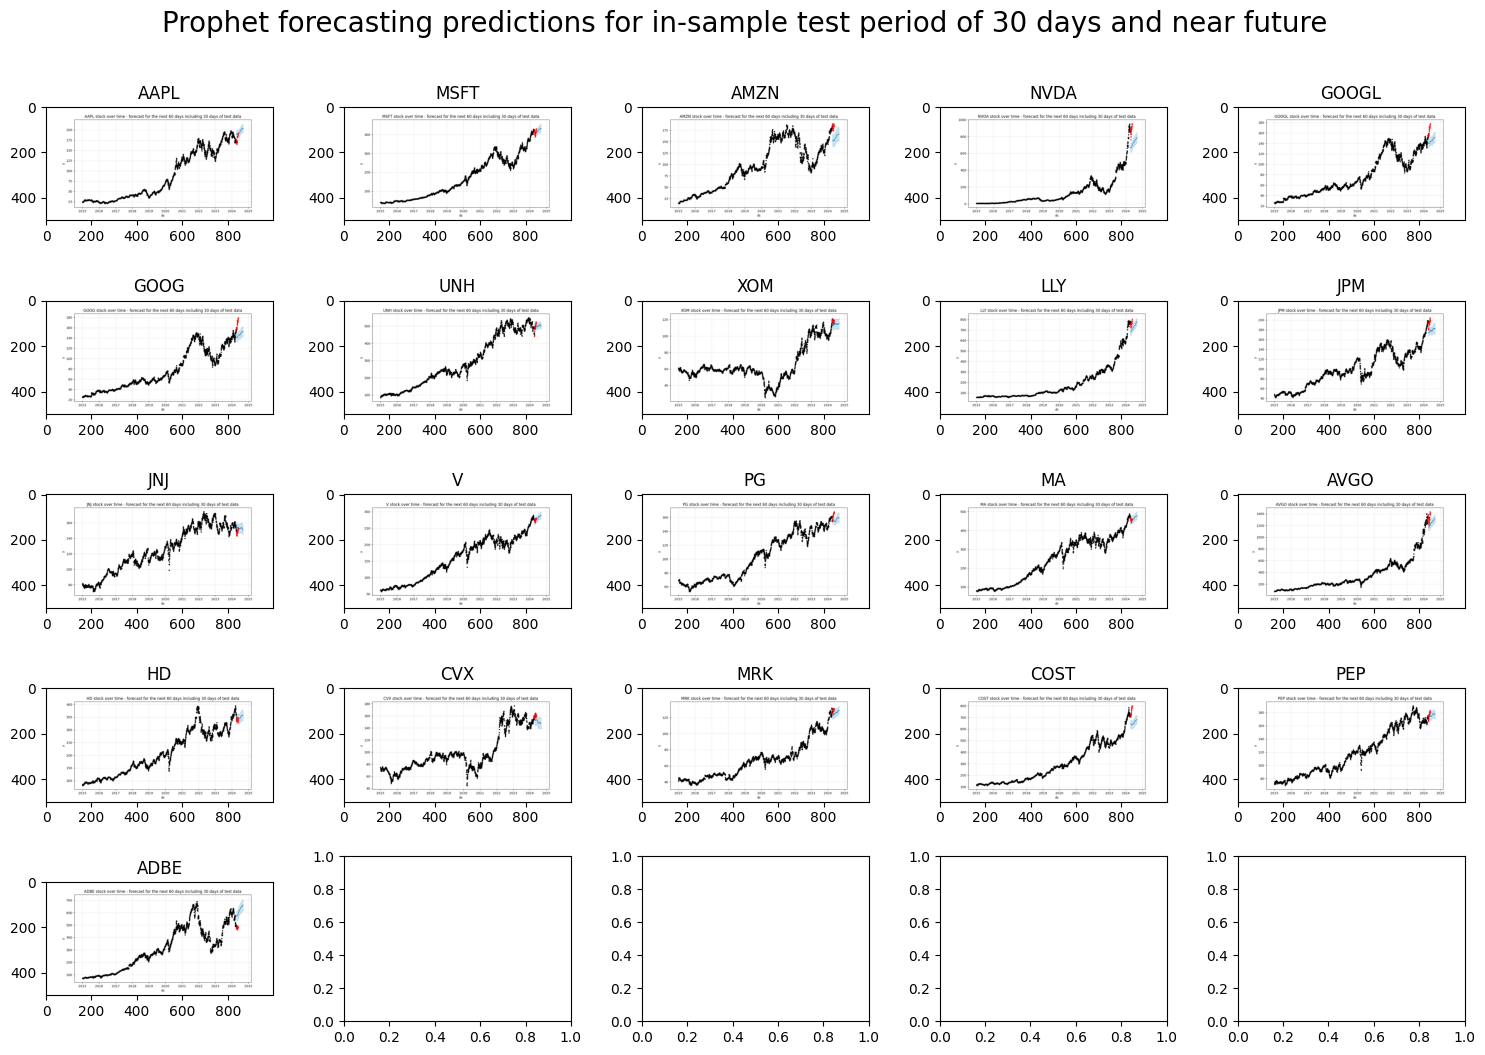

In [ ]:
# Checking if the number of stocks is a perfect square
int_sqrt = isqrt(len(existing_top_stocks))
full_sqrt = sqrt(len(existing_top_stocks))

if int_sqrt==full_sqrt: # Perfect square
    nrows=int_sqrt
    ncols=int_sqrt
else:
    nrows=int_sqrt+1
    ncols=ceil(len(existing_top_stocks)/(int_sqrt+1))

# Adding the backslash to the input directory if not present to make the location name consistent
if prophet_folder[-1] != "/":
    prophet_folder += "/"

# Showing a multifacet plot of the metrics
fig, ax = plt.subplots(nrows, ncols, figsize=(15, 10))
for i, stock in enumerate(existing_top_stocks):
    row = i // ncols
    col = i % ncols
    img_path = prophet_folder  + "prophet_e2e_forecast_" + stock + '.png'
    img = mpimg.imread(img_path)
    ax[row, col].imshow(img)
    ax[row, col].set_title(stock)
plt.tight_layout()
plt.suptitle("Prophet forecasting predictions for in-sample test period of 30 days and near future", fontsize=20, y=1.05)
plt.show()


### ARIMA

In [ ]:
# Define common variables
data_folder = '../data/'
prophet_folder = '../prophet_charts/'
data_start_date='2015-01-01'
test_size=30

### SARIMA